In [1]:
import pandas as pd
import os
from joblib import load
import sys
import numpy as np
from sklearn.metrics import r2_score
from copy import deepcopy
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets

In [2]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')

In [3]:
stat = "YDC"
proc = GatherFeatureDatasets(is_p=True)
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        test_df=all_test_df,
                                                                                        holdout_df=all_holdout_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)


In [4]:
model_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP'
preds_2023 = pd.read_csv(os.path.join(model_dir, 'YDC.P.preds.holdout.csv'))
preds_test = pd.read_csv(os.path.join(model_dir, 'YDC.P.preds.test.csv'))
scaler = load(os.path.join(model_dir, 'YDC.P.scaler.joblib'))
model = load(os.path.join(model_dir, 'YDC.P.SVR.joblib'))

In [5]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
feature_inds = np.where(np.isin(feature_names, selected_features))[0]

In [6]:
X_holdout_scaled = scaler.transform(station_feature_dict["X_holdout"][:, feature_inds])
X_train_scaled = scaler.transform(station_feature_dict["X_train"][:, feature_inds])
y_train = station_meta_dict["y_train"]

y_holdout = station_meta_dict["y_holdout"]

default_preds = model.predict(X_holdout_scaled)
assert np.allclose(default_preds, 
                   preds_2023["predicted_magnitude"].values)
X_train = station_feature_dict["X_train"][:, :]


In [7]:
# cat = pd.read_csv("../../data/catalogs/yellowstone.events.2024.csv")
# epoch2017 = datetime(2017, 1, 1, tzinfo=timezone.utc).timestamp()
# epoch2018 = datetime(2018, 1, 1, tzinfo=timezone.utc).timestamp()
# evids_2017 = cat[(cat["origin_time"] >= epoch2017) &
#                        (cat["origin_time"] < epoch2018)]["evid"]
# evids_other = cat[(cat["origin_time"] < epoch2017) |
#                        (cat["origin_time"] > epoch2018)]["evid"]
# assert ~np.any(np.isin(evids_other, evids_2017))
# assert len(evids_2017) + len(evids_other) == len(cat)
# train_evids = station_meta_dict["evids_train"]
# train_inds_2017 = np.where(train_evids.isin(evids_2017))[0]
# train_inds_other = np.where(train_evids.isin(evids_other))[0]
# assert len(train_inds_2017) + len(train_inds_other) == len(train_evids)
# X_train = X_train[train_inds_other, :]
# print(X_train.shape)
# print(X_train_scaled.shape)
# X_train_scaled = X_train_scaled[train_inds_other, :]
# print(X_train_scaled.shape)
# y_train = y_train[train_inds_other]
# print(y_train.shape)


In [8]:
start_sr_dist = 0.0
sr_dist_ind = np.where(feature_names == "source_receiver_distance_logkm")[0]
summary = []
mag_inds_dict = {}

for end_sr_dist in [2.5, 3.5, 5]:
    start_mag = 0
    mag_inds_dict[end_sr_dist] = {}
    for end_mag in np.arange(0.5, 4.0, 0.5):
        print(start_sr_dist, end_sr_dist, start_mag, end_mag)
        mag_inds = np.where((y_train >= start_mag) & (y_train < end_mag) &
                            (X_train[:, sr_dist_ind].flatten() >= start_sr_dist) & 
                            (X_train[:, sr_dist_ind].flatten() < end_sr_dist) )[0]
        mag_inds_dict[end_sr_dist][end_mag] = mag_inds
        mag_results = [start_sr_dist, end_sr_dist, start_mag, end_mag, len(mag_inds)]
        mag_results += [*np.mean(X_train_scaled[mag_inds, :], axis=0)]
        mag_results += [*np.median(X_train_scaled[mag_inds, :], axis=0)]
        summary.append(mag_results)
        start_mag = end_mag
    start_sr_dist = end_sr_dist

#station_meta_dict["y_train"]

0.0 2.5 0 0.5
0.0 2.5 0.5 1.0
0.0 2.5 1.0 1.5
0.0 2.5 1.5 2.0
0.0 2.5 2.0 2.5
0.0 2.5 2.5 3.0
0.0 2.5 3.0 3.5
2.5 3.5 0 0.5
2.5 3.5 0.5 1.0
2.5 3.5 1.0 1.5
2.5 3.5 1.5 2.0
2.5 3.5 2.0 2.5
2.5 3.5 2.5 3.0
2.5 3.5 3.0 3.5
3.5 5 0 0.5
3.5 5 0.5 1.0
3.5 5 1.0 1.5
3.5 5 1.5 2.0
3.5 5 2.0 2.5
3.5 5 2.5 3.0
3.5 5 3.0 3.5


/uufs/chpc.utah.edu/common/home/u1072028/software/pkg/miniconda3/envs/featmags/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/uufs/chpc.utah.edu/common/home/u1072028/software/pkg/miniconda3/envs/featmags/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [9]:
cols = ["start_sr_dist", "end_sr_dist", "start_mag", "end_mag", "N"]
types = ["mean", "median"]
for i in range(2):
    m = types[i]
    for j in range(7):
        cols.append(f"{selected_features[j]}_{m}")

train_mag_bin_feat_df = pd.DataFrame(summary, columns=cols)

In [10]:
train_mag_bin_feat_df

,start_sr_dist,end_sr_dist,start_mag,end_mag,N,amp_1_mean,amp_2_mean,signal_variance_mean,noise_variance_mean,source_depth_km_mean,source_receiver_distance_logkm_mean,source_receiver_back_azimuth_deg_mean,amp_1_median,amp_2_median,signal_variance_median,noise_variance_median,source_depth_km_median,source_receiver_distance_logkm_median,source_receiver_back_azimuth_deg_median
0,0.0,2.5,0.0,0.5,34,-0.560090,-0.420398,-0.292991,0.042807,0.070223,-1.543451,-0.364284,-0.511722,-0.546649,-0.174914,0.181064,0.253554,-1.510169,-0.418836
1,0.0,2.5,0.5,1.0,101,-0.136302,-0.092119,0.155578,-0.061203,0.697366,-1.695758,-0.197755,-0.182867,-0.132727,0.194834,0.031631,0.796601,-1.520243,-0.409372
2,0.0,2.5,1.0,1.5,108,0.576569,0.514885,0.761899,0.155690,1.304997,-1.941246,-0.156372,0.719123,0.564715,0.803224,0.209812,1.428188,-1.606620,-0.486754
3,0.0,2.5,1.5,2.0,68,1.222926,1.259816,1.613159,0.490191,1.115635,-1.856362,-0.003399,1.352467,1.401127,1.740381,0.429611,1.339648,-1.599652,-0.565029
4,0.0,2.5,2.0,2.5,20,1.897654,1.717558,1.978524,1.060717,1.439994,-1.731812,0.117416,2.122683,2.283818,2.221690,0.435020,1.552145,-1.451960,-0.412511
5,0.0,2.5,2.5,3.0,5,2.777671,2.710008,3.094473,1.358947,0.888683,-1.577660,-0.547066,2.842468,2.557807,3.126778,1.508803,0.816276,-1.488693,-0.545156
6,0.0,2.5,3.0,3.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.5,3.5,0.0,0.5,29,-0.809870,-0.936250,-1.209196,-0.667475,-0.393435,-0.568230,-0.267026,-0.926177,-0.646224,-1.247833,-0.443743,-0.277688,-0.654417,-0.325729
8,2.5,3.5,0.5,1.0,338,-0.568178,-0.563140,-0.830107,-0.518079,-0.101772,-0.284334,-0.183357,-0.576348,-0.492713,-0.833507,-0.396987,-0.098640,-0.320703,-0.318466
9,2.5,3.5,1.0,1.5,703,-0.168780,-0.186367,-0.308417,-0.106500,0.056898,-0.194683,-0.149372,-0.125314,-0.091566,-0.314681,-0.066981,-0.029776,-0.208775,-0.389039


In [11]:
import math
def round_up_to_nearest_half(number):
    return math.ceil(number * 2) / 2

def get_sr_dist_bin_end(sr_dist):
    if sr_dist < 2.5:
        return 2.5
    elif sr_dist < 3.5:
        return 3.5
    else:
        return 5.0

In [12]:
modified_X_holdout_scaled = np.zeros_like(X_holdout_scaled)
for i in range(len(y_holdout)):
    ex = deepcopy(X_holdout_scaled[i:i+1, :])
    print("old", ex[0, 0:3])
    mag = y_holdout[i]
    sr_dist = station_feature_dict["X_holdout"][i, sr_dist_ind]
    rounded_mag = round_up_to_nearest_half(mag)
    sr_dist_bin_end = get_sr_dist_bin_end(sr_dist)
    #print(mag, rounded_mag)
    ex[:, 0] = train_mag_bin_feat_df[(train_mag_bin_feat_df["end_mag"] == rounded_mag) & 
                                      (train_mag_bin_feat_df["end_sr_dist"] == sr_dist_bin_end)]["amp_1_median"]
    ex[:, 1] = train_mag_bin_feat_df[(train_mag_bin_feat_df["end_mag"] == rounded_mag) & 
                                      (train_mag_bin_feat_df["end_sr_dist"] == sr_dist_bin_end)]["amp_2_median"]
    ex[:, 2] = train_mag_bin_feat_df[(train_mag_bin_feat_df["end_mag"] == rounded_mag) & 
                                      (train_mag_bin_feat_df["end_sr_dist"] == sr_dist_bin_end)]["signal_variance_median"]
    modified_X_holdout_scaled[i, :] = ex
    print("new", ex[0, :3])

old [-0.78702628 -1.46255461 -1.49048175]
new [-0.18286654 -0.13272711  0.19483396]
old [-1.30099852 -1.68771999 -1.50679136]
new [0.34527055 0.37157862 0.39154198]
old [-1.02353347 -2.0077127  -1.64386848]
new [0.34527055 0.37157862 0.39154198]
old [-0.9111584  -1.45871503 -1.38287246]
new [1.03431037 1.04529988 1.26097657]
old [-1.03379542 -1.23133885 -1.01469467]
new [1.03431037 1.04529988 1.26097657]
old [-0.77875976 -1.31103652 -0.71078928]
new [1.03431037 1.04529988 1.26097657]
old [-1.02112358 -1.58732399 -1.43565346]
new [-0.12531386 -0.09156591 -0.31468112]
old [-1.17891693 -1.89433626 -1.59355581]
new [0.34527055 0.37157862 0.39154198]
old [-1.48842051 -2.05350125 -1.5406828 ]
new [0.34527055 0.37157862 0.39154198]
old [-1.00208581 -0.93288468 -0.67164995]
new [1.94366318 1.8732854  2.10010859]
old [-0.98402426 -1.85734989 -1.45417322]
new [-0.18286654 -0.13272711  0.19483396]
old [-0.43907454 -0.28059988 -0.44940253]
new [1.94366318 1.8732854  2.10010859]
old [-0.19305841 -0

In [13]:
modified_X_holdout_scaled == X_holdout_scaled

array([[False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False,

In [14]:
modified_preds_2023 = model.predict(modified_X_holdout_scaled)

In [15]:
modified_r2 = r2_score(preds_2023["magnitude"], modified_preds_2023)
modified_r2

0.7459657463953797

In [16]:
og_r2 = r2_score(preds_2023["magnitude"], preds_2023["predicted_magnitude"])
og_r2

-3.865641374647603

In [17]:
preds_2023["modified_preds"] = modified_preds_2023

In [18]:
preds_2023

,Evid,magnitude,predicted_magnitude,modified_preds
0,60530187,0.844143,0.837258,0.854075
1,60530391,1.848922,1.036573,1.881093
2,60530416,1.514478,0.947223,1.806391
3,60530456,2.346048,1.085747,2.369692
4,60530466,2.440536,1.138524,2.359536
5,60530476,2.469532,1.301397,2.388187
6,60530562,1.330527,1.029452,0.934685
7,60530616,1.665962,1.127266,1.865294
8,60530831,1.842188,1.011976,1.820856
9,60530861,2.756930,1.295791,2.850254


Text(0.5, 0, 'Actual Mag')

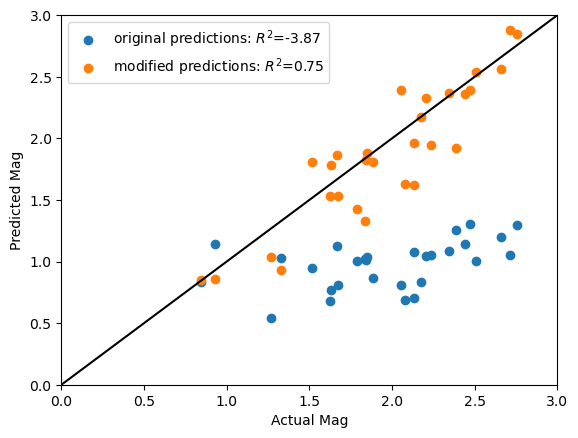

In [19]:
plt.scatter(preds_2023["magnitude"], preds_2023["predicted_magnitude"], label=f"original predictions: $R^2$={og_r2:0.2f}")
plt.scatter(preds_2023["magnitude"], preds_2023["modified_preds"], label=f"modified predictions: $R^2$={modified_r2:0.2f}")
plt.plot(np.arange(0, 4), color="k")
plt.legend()
plt.xlim([0, 3.0])
plt.ylim([0, 3.0])
plt.ylabel("Predicted Mag")
plt.xlabel("Actual Mag")

In [20]:
(X_holdout_scaled[:, 0:3] - modified_X_holdout_scaled[:, 0:3])# < 0

array([[-0.60415975, -1.3298275 , -1.68531571],
       [-1.64626907, -2.05929862, -1.89833334],
       [-1.36880402, -2.37929132, -2.03541046],
       [-1.94546877, -2.5040149 , -2.64384902],
       [-2.06810579, -2.27663872, -2.27567124],
       [-1.81307013, -2.3563364 , -1.97176585],
       [-0.89580972, -1.49575808, -1.12097234],
       [-1.52418747, -2.26591489, -1.98509779],
       [-1.83369106, -2.42507988, -1.93222478],
       [-2.94574899, -2.80617007, -2.77175853],
       [-0.80115773, -1.72462278, -1.64900718],
       [-2.38273772, -2.15388528, -2.54951111],
       [-1.22736879, -1.56232814, -1.47177585],
       [-1.71118409, -1.85862219, -2.25315373],
       [-0.75201228, -1.66537193, -1.89014819],
       [-1.38793555, -1.9101595 , -2.27170655],
       [-2.17858259, -2.27590807, -3.19425346],
       [-1.91572576, -1.73815713, -1.73271196],
       [-2.44517576, -1.74267341, -2.03431501],
       [-1.78180373, -2.16698101, -2.44156137],
       [-1.90617457, -2.03836886, -2.428